<h3 align="center"><font size="15">Projet 5 : Classifiez automatiquement des biens de consommation</font></h3>

<h3 align="center"><font size="6.5">CountVectorizer et TF-IDF</font></h3>

* [Chapitre 1 : Préparation des données texte](#chapter1)
    * [Importation des données et des librairies](#section_1_1)
    * [Catégories d'articles](#section_1_2)
        * [Détermination des catégories](#section_1_2_1)
        * [Attribution de label à chaque catégorie](#section_1_2_2)
    * [Traitements des documents](#section_1_3)
        * [Tokenisation](#section_1_3_1)
        * [Suppression de mots vides (stopwords)](#section_1_3_2)
        * [Lemmatisation](#section_1_3_3)
        * [Assemblage des tokens](#section_1_3_4)         
       
* [Chapitre 2 : Utilisation d'algorithmes sur des mots uniques](#chapter2)
    * [Test brut](#section_2_1)
        * [Préparation des données à étudier](#section_2_1_1)     
        * [Visualisation t-SNE](#section_2_1_2)
        * [Matrice de confusion](#section_2_1_3)  
    * [Filtres sur la variance](#section_2_2)
        * [Réduction du nombre de variables](#section_2_2_1)
        * [Visualisation t-SNE](#section_2_2_2)
        * [Matrice de confusion](#section_2_2_3)
    * [Filtres sur des mots](#section_2_3)
        * [Recherche de mots à supprimer](#section_2_3_1)
        * [Visualisation t-SNE](#section_2_3_2)
        * [Matrice de confusion](#section_2_3_3)
        
* [Chapitre 3 : Utilisation d'algorithmes sur des mots et suites de mots](#chapter3)
    * [Test brut](#section_3_1)
        * [Préparation des données à étudier](#section_3_1_1)     
        * [Visualisation t-SNE](#section_3_1_2)
        * [Matrice de confusion](#section_3_1_3)  
    * [Filtres sur la variance](#section_3_2)
        * [Réduction du nombre de variables](#section_3_2_1)
        * [Visualisation t-SNE](#section_3_2_2)
        * [Matrice de confusion](#section_3_2_3)
    * [Filtres sur des mots et suite de mots](#section_3_3)
        * [Recherche de mots et suite de mots à supprimer](#section_3_3_1)
        * [Visualisation t-SNE](#section_3_3_2)
        * [Matrice de confusion](#section_3_3_3)
    * [Bilan de l'étude](#section_3_4)

<a class="anchor" id="chapter1"></a>
# Chapitre 1 : Préparation des données textes

<a class="anchor" id="section_1_1"></a>
## Importation des données et des librairies

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import scipy.stats as st
import random
import itertools
import datetime
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import cluster, metrics, manifold, decomposition, preprocessing
from sklearn import manifold, decomposition
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
from matplotlib.collections import LineCollection
from matplotlib import colors
from itertools import chain
from matplotlib.lines import Line2D
import statsmodels.api as sm

data_fk = pd.read_csv("flipkart_com-ecommerce_sample_1050.csv", low_memory=False)

In [47]:
display(data_fk.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

None

In [48]:
# Nous déterminons le pourcentage de valeurs nulles (NaN)
data_fk["NAN"] = (data_fk.iloc[:,:].isna().sum(axis=1))

# Nous déterminons la taille du fichier 
taile_data = data_fk.shape[0]*data_fk.shape[1]

# Nous calculons le pourcentage de valeurs nulles dans l'ensemble du fichier 
data_missing = round(data_fk["NAN"].sum()*100/taile_data,2)
display(f"Pour le fichier Flipkart, il y a {data_missing} % de données manquantes")

data_fk = data_fk.drop(columns="NAN")

'Pour le fichier Flipkart, il y a 2.03 % de données manquantes'

In [49]:
data_fk_dup = data_fk.duplicated(keep=False).sum()
print(f"Pour le fichier FlipKart, il y a {data_fk_dup} doublons" "\n")

Pour le fichier FlipKart, il y a 0 doublons



In [51]:
# Nous visualisons un document afin de voir un descriptif typique
display(data_fk.iloc[583]["description"])

'Timewel 1100-N1944_B Analog Watch  - For Women - Buy Timewel 1100-N1944_B Analog Watch  - For Women  1100-N1944_B Online at Rs.855 in India Only at Flipkart.com. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!'

<a class="anchor" id="section_1_2"></a>
## Catégories d'articles

<a class="anchor" id="section_1_2_1"></a>
### Détermination des catégories

Nous allons créer une variables dans laquelle nous associons chaque article à la catégorie principale à laquelle l'article appartient. Pour cela nous nous basons sur la variable "product_category_tree".

In [52]:
data_categ = data_fk["product_category_tree"].str.split((" >> "), expand=True)
display(data_categ.shape)

(1050, 7)

In [53]:
data_categ = data_categ.rename(columns={0 : "Main_category", 1 : "Category_2", 2 : "Category_3", 
                                        3 : "Category_4", 4 : "Category_5", 5 : "Category_6", 
                                        6 : "Category_7"})

In [54]:
data_categ["Main_category"] = data_categ["Main_category"].str.replace(r"\[", "", regex = True)
data_categ = data_categ.replace(r"\"", "", regex = True)
data_categ = data_categ.replace(r"\]", "", regex = True)
display(data_categ["Main_category"].value_counts().sort_index())

Baby Care                     150
Beauty and Personal Care      150
Computers                     150
Home Decor & Festive Needs    150
Home Furnishing               150
Kitchen & Dining              150
Watches                       150
Name: Main_category, dtype: int64

<a class="anchor" id="section_1_2_2"></a>
### Attribution de label à chaque catégorie

7 catégories ont été déterminées. Nous allons attribuer une valeur comprise entre 0 et 6 à chaque catégorie.

In [55]:
liste_categ = sorted(data_categ["Main_category"].unique().tolist())

print(liste_categ)
for i in range (0, len(liste_categ),1):
    data_categ.loc[data_categ["Main_category"] == liste_categ[i], "category_label"] = i
display(data_categ["category_label"].value_counts().sort_index())

['Baby Care', 'Beauty and Personal Care', 'Computers', 'Home Decor & Festive Needs', 'Home Furnishing', 'Kitchen & Dining', 'Watches']


0.0    150
1.0    150
2.0    150
3.0    150
4.0    150
5.0    150
6.0    150
Name: category_label, dtype: int64

In [56]:
data = pd.merge(data_fk, data_categ[["Main_category", "category_label"]], left_index=True, right_index=True, how="outer")

data["category_label"] = data["category_label"].astype(int)

data = data.sort_values("category_label").reset_index(drop=True)

Nous allons traiter les documents de telles sortes à pouvoir utiliser les algorithmes. Il est important de distinguer deux traitement différent :
- traitement pour les algorithmes de type "bag of words" et Word2vec : ces algorithmes se basent sur les mots (ou suite de mots) et le contexte n'a pas d'impact. C'est pourquoi, pour chaque document, nous allons :
    - extraire l'ensemble des tokens, 
    - puis supprimer les stopwords, 
    - lemmatiser les mots et 
    - assembler les tokens restants
    
- traitement pour les algorithmes de type BERT et USE : il est fondamental de conserver le contexte car cela a un impact pour ces deux méthodes. Dans le cas de BERT, il y a un apprentissage de la langue, d'où l'intérêt de garder coserver les mots et les stopwords. Dans le cas de USE, il est nécessaire de garder les phrases telles quelles car l'algirthme se base sur la compréhension des phrases. C'est pourquoi, pour chaque document, nous allons :
    - extraire l'ensemble des tokens et
    - les assembler.
    

<a class="anchor" id="section_1_3"></a>
## Traitements des documents

<a class="anchor" id="section_1_3_1"></a>
### Tokenisation

In [57]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

data["word_tok"] = data.iloc[:]["description"].str.lower().apply(lambda x : (word_tokenize(x)))

words_test = word_tokenize(data.iloc[583,10].lower())

# display(data.iloc[5:8,9:])

In [58]:
print(words_test)

['buy', 'lal', 'haveli', 'rajasthani', 'wooden', 'crafted', 'unique', 'chowkidar', 'statues', 'wooden', 'darwam', 'showpiece', '-', '50.8', 'cm', 'for', 'rs.4795', 'online', '.', 'lal', 'haveli', 'rajasthani', 'wooden', 'crafted', 'unique', 'chowkidar', 'statues', 'wooden', 'darwam', 'showpiece', '-', '50.8', 'cm', 'at', 'best', 'prices', 'with', 'free', 'shipping', '&', 'cash', 'on', 'delivery', '.', 'only', 'genuine', 'products', '.', '30', 'day', 'replacement', 'guarantee', '.']


<a class="anchor" id="section_1_3_2"></a>
### Suppression de mots vides (stopwords)

In [59]:
from nltk.corpus import stopwords

stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')', '!', '-']

filtered_w = [w for w in words_test if not w in stop_w]

data["stop_word_tok"] = data["word_tok"].apply(lambda x: [item for item in x if item not in stop_w])

<a class="anchor" id="section_1_3_3"></a>
### Lemmatisation

In [60]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
data["lemmatize_stop_word_tok"] = data["stop_word_tok"].apply(lambda lst:[lemmatizer.lemmatize(word) for word in lst])
lem_w = [lemmatizer.lemmatize(w) for w in filtered_w]

# print((lem_w))

<a class="anchor" id="section_1_3_4"></a>
### Assemblage des tokens

In [61]:
data["text_clean"] = data["lemmatize_stop_word_tok"].apply(lambda lst:[' '.join(lst)])
data["text_clean_deep_l"] = data["word_tok"].apply(lambda lst:[' '.join(lst)])
transf_desc_text = ' '.join(lem_w)
# print(transf_desc_text)

In [62]:
data["text_clean"] = data["text_clean"].astype(str)

data["text_clean"] = data["text_clean"].str.replace(r"\[", "", regex = True)
data["text_clean"] = data["text_clean"].replace(r"\'", "", regex = True)
data["text_clean"] = data["text_clean"].replace(r"\]", "", regex = True)

data["text_clean_deep_l"] = data["text_clean_deep_l"].astype(str)

data["text_clean_deep_l"] = data["text_clean_deep_l"].str.replace(r"\[", "", regex = True)
data["text_clean_deep_l"] = data["text_clean_deep_l"].replace(r"\'", "", regex = True)
data["text_clean_deep_l"] = data["text_clean_deep_l"].replace(r"\]", "", regex = True)

La partie précédente avait pour but de préparer le texte à analyser. Dans la suite du notebook, nous allons utiliser les algorithmes CountVectorizer et TF-IDFVectorizer. Dans les deux algorithmes, nous comptons l'apparition de chaque token dans chaque document ce qui va générer une matrice creuse. La principale différence entre ces deux méthodes et le fait qu'un poids est affecté à chaque token pour l'algorithme TF-IDFVectorizer. Ce poids correspond au produit de la fréquence d'un terme (TF) par la fréquence inverse d'un mot dans l'ensemble du corpus (IDF).

Nous allons imposer qu'un token apparaisse au maximum dans 50 % des documents et nous étudierons uniquement les mots uniques. Enfin, nous allons ajouter quelques mots à ne pas considérer propre à la thématique (garantie, unités de mesure, nom du site web...).

<a class="anchor" id="chapter2"></a>
# Chapitre 2 : Utilisation d'algorithmes sur des mots uniques

<a class="anchor" id="section_2_1"></a>
## Test brut

<a class="anchor" id="section_2_1_1"></a>
### Préparation des données à étudier

In [22]:
stop_w_2 = stop_w + ["cm", "day", "guarantee", "shipping", "delivery", "g", "kg", 
                     "buy", "cash", "free", "genuine", "price", "product", "products",
                     "replacement", "30", "online", "flipkart", "com", "flipkart.com",
                     "specification", "specifications"]

In [23]:
cvect = CountVectorizer(max_df = 0.5, min_df = 1, max_features = 3000, stop_words=stop_w_2)
ctf = TfidfVectorizer(max_df = 0.5, min_df = 1, max_features = 3000, stop_words=stop_w_2)

cv_fit = cvect.fit(data["text_clean"].values)
ctf_fit = ctf.fit(data["text_clean"].values)

cv_transform = cvect.transform(data["text_clean"].values)  
ctf_transform = ctf.transform(data["text_clean"].values)  

In [24]:
df_cvect = pd.merge(data[["Main_category", "category_label"]], 
                    pd.DataFrame(data=cv_transform.toarray(), columns = cvect.get_feature_names_out()), 
                    left_index=True, right_index=True, how="outer")
display(df_cvect.shape)

df_tfidf = pd.merge(data[["Main_category", "category_label"]],
                    pd.DataFrame(data=ctf_transform.toarray(), columns = ctf.get_feature_names_out()), 
                    left_index=True, right_index=True, how="outer")
display(df_tfidf.shape)

(1050, 3002)

(1050, 3002)

In [26]:
X_cvect = df_cvect.iloc[:,2:].values

X_tfidf = df_tfidf.iloc[:,2:].values

lab_category = data["category_label"].values
n_clusters = len(data["Main_category"].unique())

<a class="anchor" id="section_2_1_2"></a>
### Visualisation t-SNE

Dans cette partie, nous allons employer une méthodologie qui sera appliqué à l'ensemble des autre algorithmes. 

En premier lieu, nous allons faire une réduction de dimension via un t-SNE et passer donc de X dimensions à 2 dimensions de telles sortes à pouvoir représenter les données réduites sur formes de graphiques. 
Ensuite, nous allons faire une segmentation des données réduites en 7, ce qui correspond au nombre de catégories. 
Nous visualisons alors les données réduites en représentant chaque catégorie réelle d'une couleur distincte. 
Pour cela, nous devons déterminer au préalable la meilleure perplexité et nous déterminons pour chaque valeur de perplexité choisie (entre 5 et 100 avec un pas de 5) le score ARI entre les labels obtenus après une segmentation des données avec une perplexité donnée et les catégories réelles qui ont été encodées dans la partie précédente.

Enfin, nous traçons une matrice de confusion afin de déterminer s'il y a une bonne correspondance entre les catégories réelles et celle prédites par la segmentation.

Les fonctions permettant de faire cela ont été définies dans un fichier appelé "Fonction_P6" et ce fichier sera importé sur chaque notebook.

In [25]:
import Fonction_P6 as p6

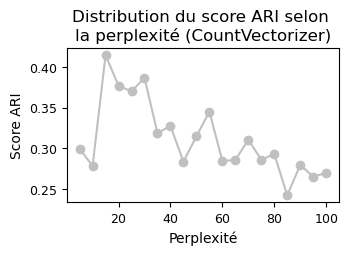

In [27]:
best_perp_cvect = p6.best_perplexity(lab_category, X_cvect, "CountVectorizer", 
                                     perp_min = 5, perp_max = 105, step = 5, n_clusters = n_clusters)

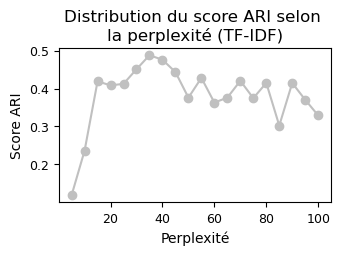

In [28]:
best_perp_tfidf = p6.best_perplexity(lab_category, X_tfidf, "TF-IDF", 
                                     perp_min = 5, perp_max = 105, step = 5, n_clusters = n_clusters)

Pour le modèle CountVectorizer, le score ARI est : 0.41697


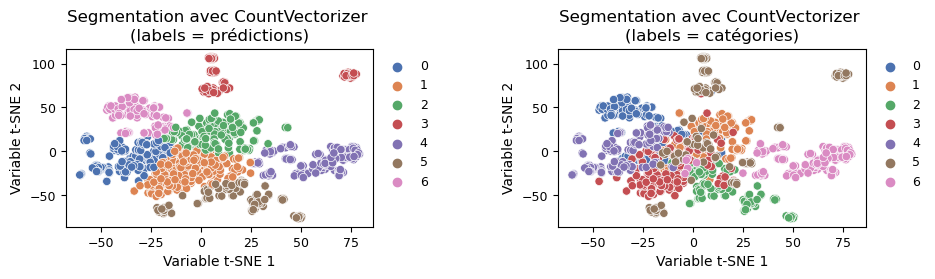

In [29]:
ARI_cvect, lab_cvect = p6.graph_t_sne("CountVectorizer", best_perp_cvect, X_cvect, lab_category, n_clusters = 7)

Pour le modèle TF-IDF, le score ARI est : 0.48778


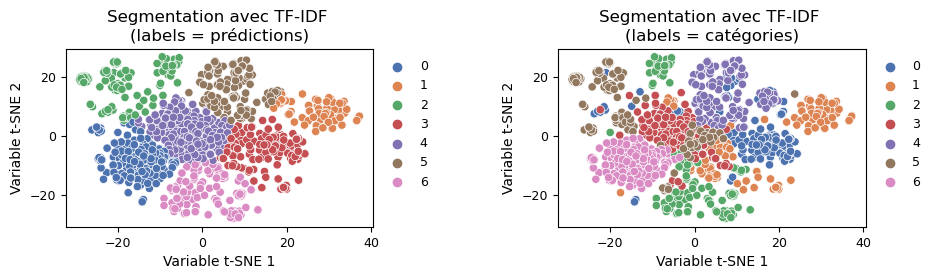

In [30]:
ARI_tfidf, lab_tfidf = p6.graph_t_sne("TF-IDF", best_perp_tfidf, X_tfidf, lab_category, n_clusters = 7)

In [31]:
method = []
Score_ARI = []
method.append("3000\nmots")
method.append("3000\nmots")
Score_ARI.append(ARI_cvect)
Score_ARI.append(ARI_tfidf)

<a class="anchor" id="section_2_1_3"></a>
### Matrice de confusion

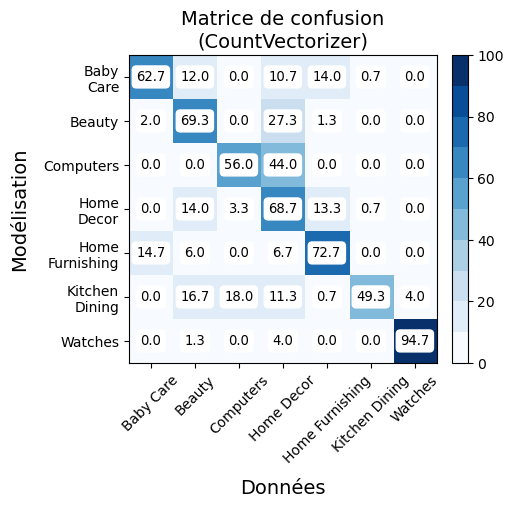

In [32]:
data["label_cvect_1"] = pd.Series(lab_cvect)
data["label_tfidf_1"] = pd.Series(lab_tfidf)

p6.graph_matrix(data["category_label"], data["label_cvect_1"], "CountVectorizer")

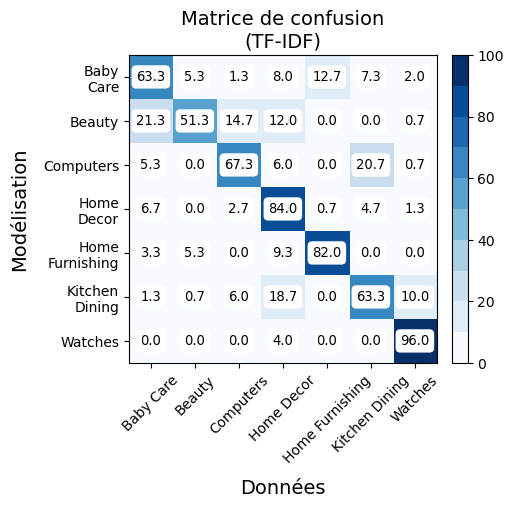

In [33]:
p6.graph_matrix(data["category_label"], data["label_tfidf_1"], "TF-IDF")

Nous voyons que l'algorithme CountVectorizer est moins efficace que l'algorithme TF-IDFVectorizer car les scores ARI sont respectivement de 0.417 et 0.488. Avec ces deux algorithmes, les articles de la catégorie montre sont bien retrouvées. En revanche, ce n'est pas le cas avec la plupart des autres catégories. Il est à noter que les catégories décorations d'intérieures et meubles de maisons sont mieux iddentifiées avec TF-IDFVectorizer.

Nous allons reprendre la même étude en ne conservant les variables qui possèdent le plus de variances.

<a class="anchor" id="section_2_2"></a>
## Filtres sur la variance

<a class="anchor" id="section_2_1_1"></a>
### Réduction du nombre de variables

In [34]:
var_cvect = pd.DataFrame(df_cvect.iloc[:,2:].var(), index=df_cvect.iloc[:,2:].columns, columns={"Variance"})
var_cvect = var_cvect.reset_index()
var_cvect = var_cvect.sort_values("Variance", ascending = False).reset_index(drop=True)

var_tfidf = pd.DataFrame(df_tfidf.iloc[:,2:].var(), index=df_tfidf.iloc[:,2:].columns, columns={"Variance"})
var_tfidf = var_tfidf.reset_index()
var_tfidf = var_tfidf.sort_values("Variance", ascending = False).reset_index(drop=True)

In [35]:
columns_to_keep_cvect = var_cvect.iloc[:1050,0]

df_cvect_filtered = df_cvect[columns_to_keep_cvect]

columns_to_keep_tfidf = var_tfidf.iloc[:1050,0]

df_tfidf_filtered = df_tfidf[columns_to_keep_tfidf]

display(df_cvect_filtered.shape)
display(df_tfidf_filtered.shape)

X_cvect_filt = df_cvect_filtered.values

X_tfidf_filt = df_tfidf_filtered.values

(1050, 1050)

(1050, 1050)

<a class="anchor" id="section_2_2_2"></a>
### Visualisation t-SNE

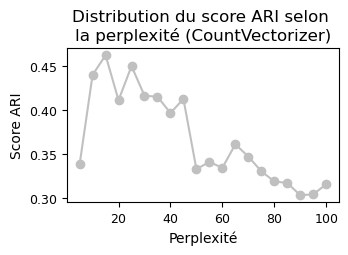

In [36]:
best_perp_cvect_filt = p6.best_perplexity(lab_category, X_cvect_filt, "CountVectorizer", 
                                          perp_min = 5, perp_max = 105, step = 5, n_clusters = n_clusters)

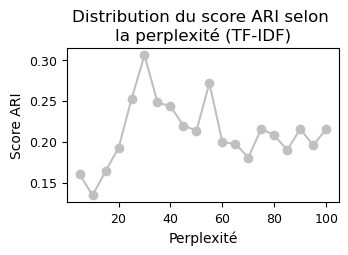

In [37]:
best_perp_tfidf_filt = p6.best_perplexity(lab_category, X_tfidf_filt, "TF-IDF", 
                                          perp_min = 5, perp_max = 105, step = 5, n_clusters = n_clusters)

Pour le modèle CountVectorizer, le score ARI est : 0.39507


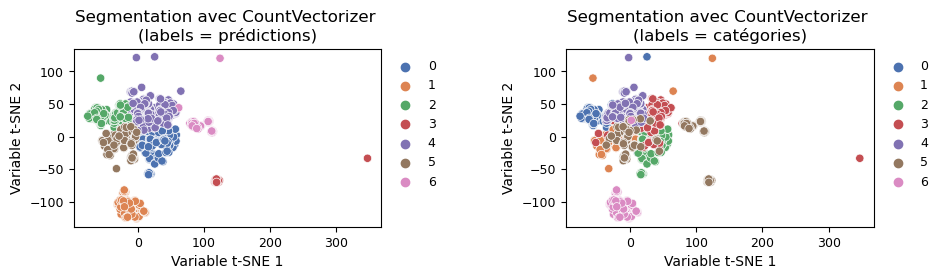

In [38]:
ARI_cvect_2, lab_cvect_2, = p6.graph_t_sne("CountVectorizer", best_perp_cvect_filt, X_cvect_filt, lab_category, n_clusters = 7)

Pour le modèle TF-IDF, le score ARI est : 0.30559


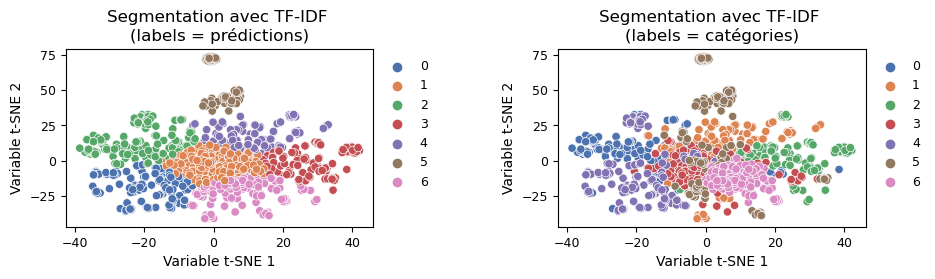

In [39]:
ARI_tfidf_2, lab_tfidf_2 = p6.graph_t_sne("TF-IDF", best_perp_tfidf_filt, X_tfidf_filt, lab_category, n_clusters = 7)

In [40]:
method.append("Filtres var.")
method.append("Filtres var.")
Score_ARI.append(ARI_cvect_2)
Score_ARI.append(ARI_tfidf_2)

<a class="anchor" id="section_2_2_3"></a>
### Matrice de confusion

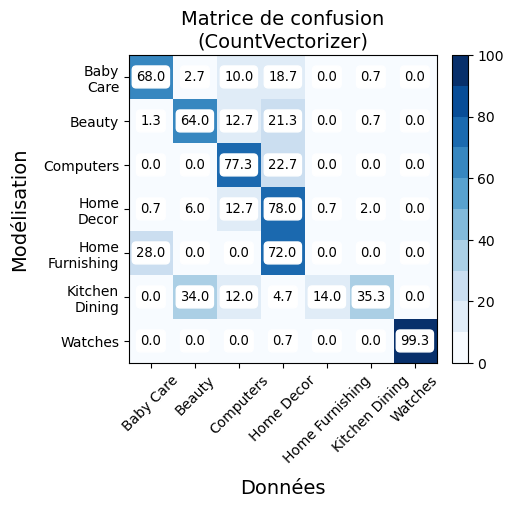

In [41]:
data["label_cvect_2"] = pd.Series(lab_cvect_2)
data["label_tfidf_2"] = pd.Series(lab_tfidf_2)

p6.graph_matrix(data["category_label"], data["label_cvect_2"], "CountVectorizer")

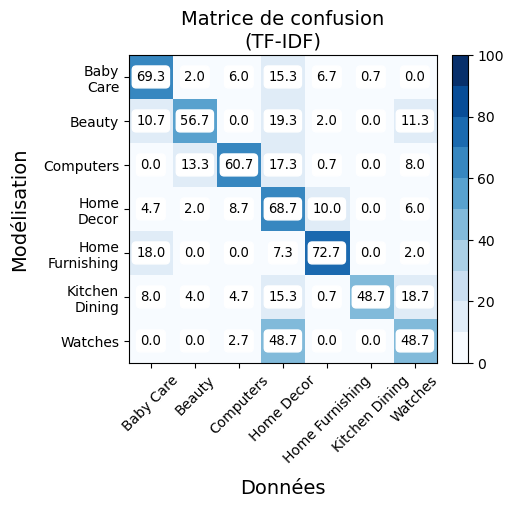

In [42]:
p6.graph_matrix(data["category_label"], data["label_tfidf_2"], "TF-IDF")

Globalement, le fait d'appliquer des filtres sur la variance diminue le score ARI, notamment pour l'algorithme TF-IDFVectorizer. Nous allons essayer d'appliquer un filtres sur les mots. L'idée est de déterminer les 30 mots les plus présents pour chaque catégorie, puis de supprimer les mots qui apparaissent dans plusieurs catégories et qui ont un caractère général ou qui n'apporte rien à l'identification d'une catégorie. 

<a class="anchor" id="section_2_3"></a>
## Filtres sur des mots

<a class="anchor" id="section_2_1_1"></a>
### Recherche de mots à supprimer

In [43]:
liste_dico_cvect = [col for col in df_cvect.iloc[:,2:].columns]
for i in range(len(liste_dico_cvect)):
    liste_dico_cvect[i] = {}
    
i=0
for col in df_cvect.iloc[:,2:].columns:
    for cat in data["Main_category"].unique():
        liste_dico_cvect[i][f"{cat}"] = df_cvect.loc[df_cvect["Main_category"]==cat, col].sum()
    i+=1
    
liste_dico_cvect_df = pd.DataFrame(liste_dico_cvect, index = df_cvect.iloc[:,2:].columns).reset_index()
liste_dico_cvect_df = liste_dico_cvect_df.rename(columns = {"index" : "Colonne"})

In [44]:
words_to_remove = ["cotton", "detail", "fabric", "boy", "ideal", "general", "package", "feature", "sale", "type", 
                   "color", "wash", "number", "pattern", "pack", "content", "box", "printed", "key", "length", 
                   "combo", "ml", "best", "warranty", "soft", "material", "rs", "quality", "brand", "model", "print", 
                   "size", "shape", "please", "high", "inch", "dimension", "made", "width", "height", "code", 
                   "perfect", "give", "come"]

print(len(words_to_remove))

44


In [45]:
col_to_keep = df_cvect.iloc[:,2:].columns

display(len(col_to_keep))
col_to_keep = [elem for elem in col_to_keep if elem not in words_to_remove]
display(len(col_to_keep))

df_cvect_less_words = df_cvect[col_to_keep]
df_tfidf_less_words = df_tfidf[col_to_keep]
display(df_cvect_less_words.shape)
display(df_tfidf_less_words.shape)

X_cvect_3 = df_cvect_less_words.values

X_tfidf_3 = df_tfidf_less_words.values

3000

2956

(1050, 2956)

(1050, 2956)

<a class="anchor" id="section_2_3_2"></a>
### Visualisation t-SNE

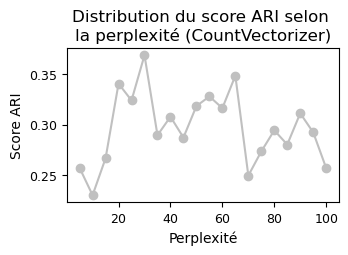

In [46]:
best_perp_cvect_3 = p6.best_perplexity(lab_category, X_cvect_3, "CountVectorizer", 
                                       perp_min = 5, perp_max = 105, step = 5, n_clusters = n_clusters)

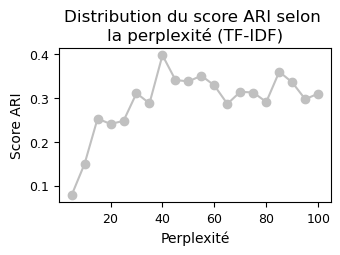

In [47]:
best_perp_tfidf_3 = p6.best_perplexity(lab_category, X_tfidf_3, "TF-IDF", 
                                       perp_min = 5, perp_max = 105, step = 5, n_clusters = n_clusters)

Pour le modèle CountVectorizer, le score ARI est : 0.36887


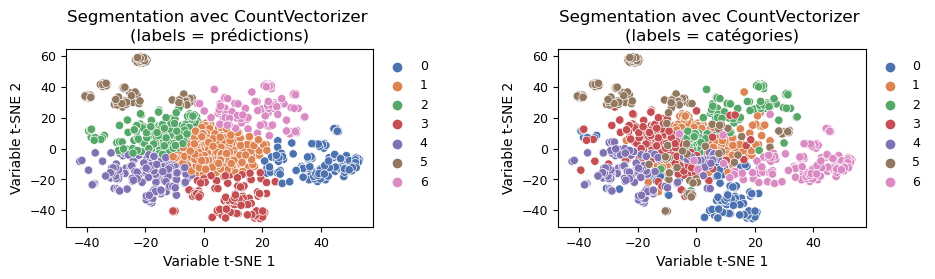

In [48]:
ARI_cvect_3, lab_cvect_3 = p6.graph_t_sne("CountVectorizer", best_perp_cvect_3, X_cvect_3, lab_category, n_clusters = 7)

Pour le modèle TF-IDF, le score ARI est : 0.39829


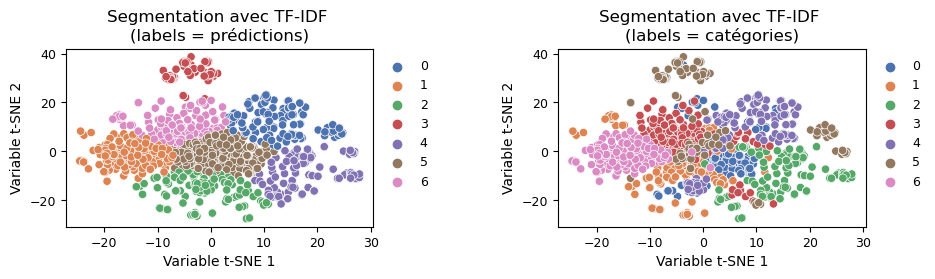

In [49]:
ARI_tfidf_3, lab_tfidf_3 = p6.graph_t_sne("TF-IDF", best_perp_tfidf_3, X_tfidf_3, lab_category, n_clusters = 7)

In [50]:
method.append("Filtres\nmots")
method.append("Filtres\nmots")
Score_ARI.append(ARI_cvect_3)
Score_ARI.append(ARI_tfidf_3)

<a class="anchor" id="section_2_3_3"></a>
### Matrice de confusion

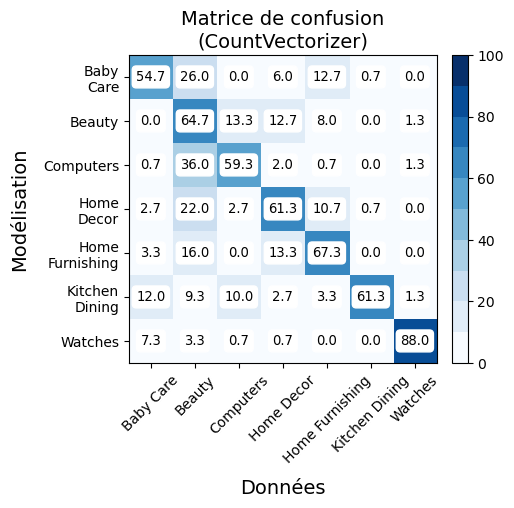

In [51]:
data["label_cvect_3"] = pd.Series(lab_cvect_3)
data["label_tfidf_3"] = pd.Series(lab_tfidf_3)

p6.graph_matrix(data["category_label"], data["label_cvect_3"], "CountVectorizer")

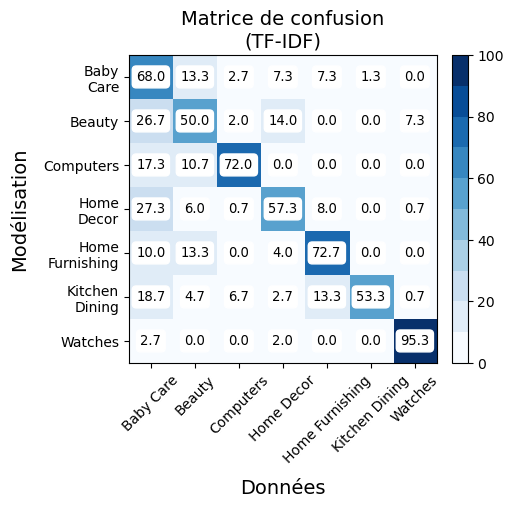

In [52]:
p6.graph_matrix(data["category_label"], data["label_tfidf_3"], "TF-IDF")

Le fait d'appliquer un filtre sur les mots fait diminuer le score ARI et la plupart des correspondances entre les catégories prédites et réelles. 

Nous allons reprendre la même étude mais en considérant à la fois des mots uniques, des bi-grammes et des tri-grammes.

<a class="anchor" id="chapter3"></a>
# Chapitre 3 : Utilisation d'algorithmes sur des mots et suites de mots

<a class="anchor" id="section_3_1"></a>
## Test brut

<a class="anchor" id="section_3_1_1"></a>
### Préparation des données à étudier

In [26]:
cvect_2_3 = CountVectorizer(max_df=0.5, min_df=1, ngram_range = (1,3), max_features = 5000, stop_words = stop_w_2)
ctf_2_3 = TfidfVectorizer(max_df=0.5, min_df=1, ngram_range = (1,3), max_features = 5000, stop_words = stop_w_2)

cv_2_3_transform = cvect_2_3.fit_transform(data["text_clean"].values)
ctf_2_3_transform = ctf_2_3.fit_transform(data["text_clean"].values)

In [27]:
df_cvect_2_3 = pd.merge(data[["Main_category", "category_label"]], 
                        pd.DataFrame(data=cv_2_3_transform.toarray(), columns = cvect_2_3.get_feature_names_out()), 
                        left_index=True, right_index=True, how="outer")
display(df_cvect_2_3.shape)

df_tfidf_2_3 = pd.merge(data[["Main_category", "category_label"]],
                        pd.DataFrame(data=ctf_2_3_transform.toarray(), columns = ctf_2_3.get_feature_names_out()), 
                        left_index=True, right_index=True, how="outer")
display(df_tfidf_2_3.shape)

X_cvect_2_3 = df_cvect_2_3.iloc[:,2:].values

X_tfidf_2_3 = df_tfidf_2_3.iloc[:,2:].values

(1050, 5002)

(1050, 5002)

<a class="anchor" id="section_3_1_2"></a>
### Visualisation t-SNE

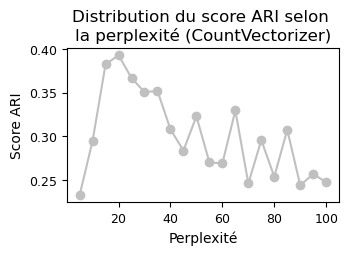

In [55]:
best_perp_cvect_2_3 = p6.best_perplexity(lab_category, X_cvect_2_3, "CountVectorizer", 
                                         perp_min = 5, perp_max = 105, step = 5, n_clusters = n_clusters)

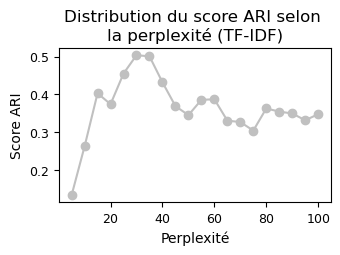

In [56]:
best_perp_tfidf_2_3 = p6.best_perplexity(lab_category, X_tfidf_2_3, "TF-IDF", 
                                         perp_min = 5, perp_max = 105, step = 5, n_clusters = n_clusters)

Pour le modèle CountVectorizer, le score ARI est : 0.3929


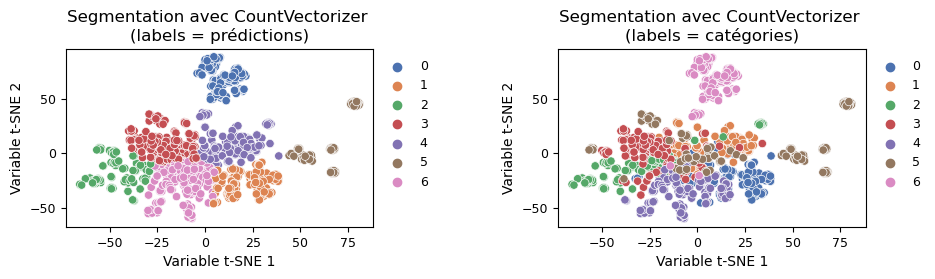

In [57]:
ARI_cvect_bi, lab_cvect_bi = p6.graph_t_sne("CountVectorizer", best_perp_cvect_2_3, X_cvect_2_3, lab_category, n_clusters = 7)

Pour le modèle TF-IDF, le score ARI est : 0.5037


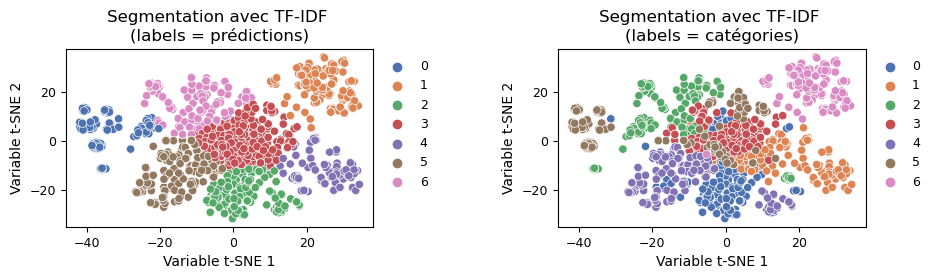

In [58]:
ARI_tfidf_bi, lab_tfidf_bi = p6.graph_t_sne("TF-IDF", best_perp_tfidf_2_3, X_tfidf_2_3, lab_category, n_clusters = 7)

In [59]:
method.append("Bi-tri-gram")
method.append("Bi-tri-gram")
Score_ARI.append(ARI_cvect_bi)
Score_ARI.append(ARI_tfidf_bi)

<a class="anchor" id="section_3_1_3"></a>
### Matrice de confusion

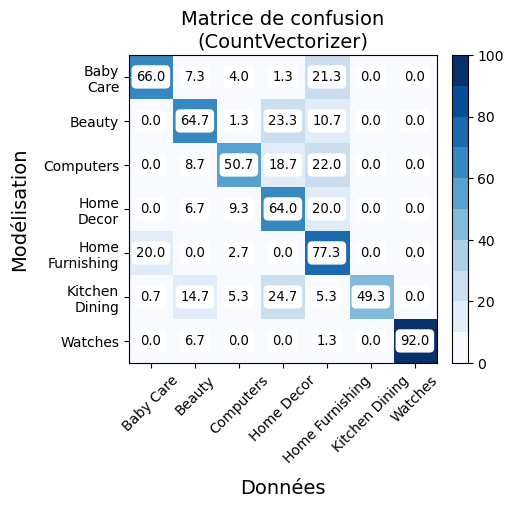

In [60]:
data["label_cvect_bi"] = pd.Series(lab_cvect_bi)
data["label_tfidf_bi"] = pd.Series(lab_tfidf_bi)

p6.graph_matrix(data["category_label"], data["label_cvect_bi"], "CountVectorizer")

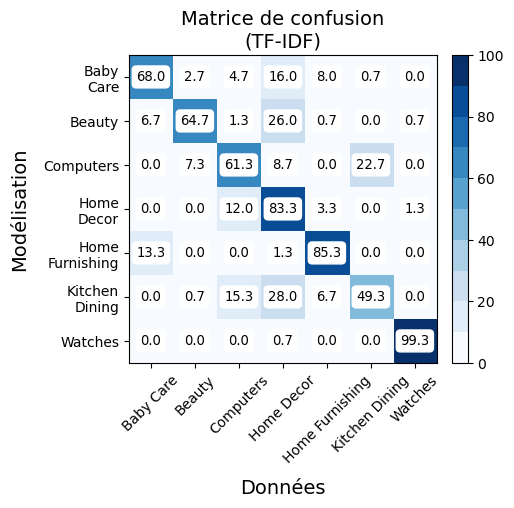

In [61]:
p6.graph_matrix(data["category_label"], data["label_tfidf_bi"], "TF-IDF")

Nous pouvons voir que le fait de travailler avec des bi-grammes et des tri-grammes améliore le score ARI pour l'algorithme TF-IDFVectorizer mais pas pour l'algorithme CountVectorizer. Comme précédemment, nous allons étudier l'impact d'un filtre des variables sur la variance.

<a class="anchor" id="section_3_2"></a>
## Filtres sur la variance

<a class="anchor" id="section_3_1_1"></a>
### Réduction du nombre de variables

In [62]:
var_cvect_2_3 = pd.DataFrame(df_cvect_2_3.iloc[:,2:].var(), index = df_cvect_2_3.iloc[:,2:].columns, columns={"Variance"})
var_cvect_2_3 = var_cvect_2_3.reset_index()
var_cvect_2_3 = var_cvect_2_3.sort_values("Variance", ascending = False).reset_index(drop=True)


var_tfidf_2_3 = pd.DataFrame(df_tfidf_2_3.iloc[:,2:].var(), index = df_tfidf_2_3.iloc[:,2:].columns, columns={"Variance"})
var_tfidf_2_3 = var_tfidf_2_3.reset_index()
var_tfidf_2_3 = var_tfidf_2_3.sort_values("Variance", ascending = False).reset_index(drop=True)

columns_to_keep_cvect_2_3 = var_cvect_2_3.iloc[:1050,0]

df_cvect_2_3_filtered = df_cvect_2_3[columns_to_keep_cvect_2_3]

columns_to_keep_tfidf_2_3 = var_tfidf_2_3.iloc[:1050,0]

df_tfidf_2_3_filtered = df_tfidf_2_3[columns_to_keep_tfidf_2_3]

X_cvect_2_3_red = df_cvect_2_3_filtered.values

X_tfidf_2_3_red = df_tfidf_2_3_filtered.values

print(X_tfidf_2_3_red.shape)

(1050, 1050)


<a class="anchor" id="section_3_2_2"></a>
### Visualisation t-SNE

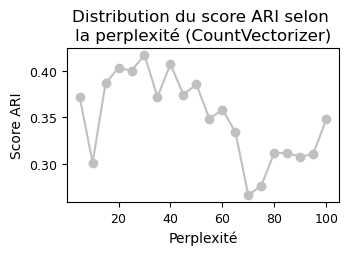

In [63]:
best_perp_cvect_2_3_red = p6.best_perplexity(lab_category, X_cvect_2_3_red, "CountVectorizer", 
                                             perp_min = 5, perp_max = 105, step = 5, n_clusters = n_clusters)

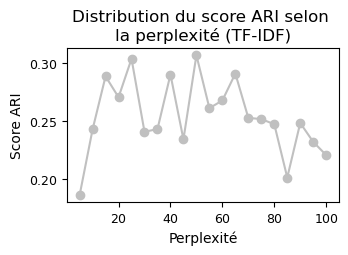

In [64]:
best_perp_tfidf_2_3_red = p6.best_perplexity(lab_category, X_tfidf_2_3_red, "TF-IDF", 
                                             perp_min = 5, perp_max = 105, step = 5, n_clusters = n_clusters)

Pour le modèle CountVectorizer, le score ARI est : 0.41683


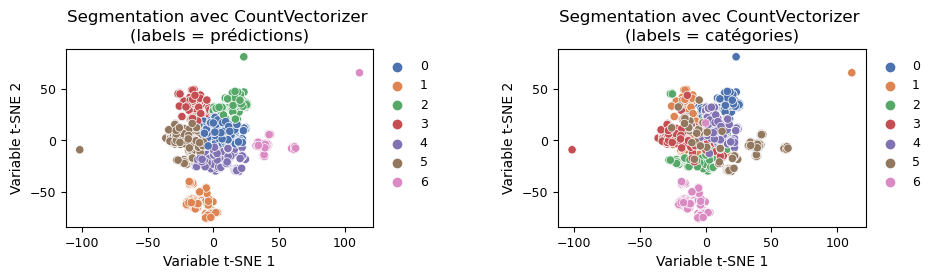

In [65]:
ARI_cvect_bi_2, lab_cvect_bi_2 = p6.graph_t_sne("CountVectorizer", best_perp_cvect_2_3_red,
                                                X_cvect_2_3_red, lab_category, n_clusters = 7)

Pour le modèle TF-IDF, le score ARI est : 0.30689


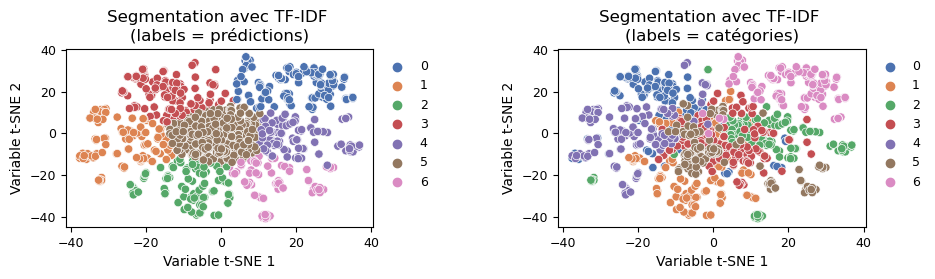

In [66]:
ARI_tfidf_bi_2, lab_tfidf_bi_2 = p6.graph_t_sne("TF-IDF", best_perp_tfidf_2_3_red, 
                                                X_tfidf_2_3_red, lab_category, n_clusters = 7)

In [67]:
method.append("Filtres var.\n(bi-tri)")
method.append("Filtres var.\n(bi-tri)")
Score_ARI.append(ARI_cvect_bi_2)
Score_ARI.append(ARI_tfidf_bi_2)

<a class="anchor" id="section_3_2_3"></a>
### Matrice de confusion

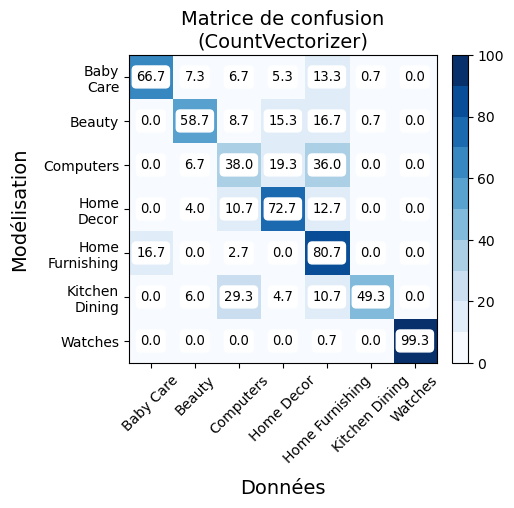

In [68]:
data["label_cvect_bi_2"] = pd.Series(lab_cvect_bi_2)
data["label_tfidf_bi_2"] = pd.Series(lab_tfidf_bi_2)

p6.graph_matrix(data["category_label"], data["label_cvect_bi_2"], "CountVectorizer")

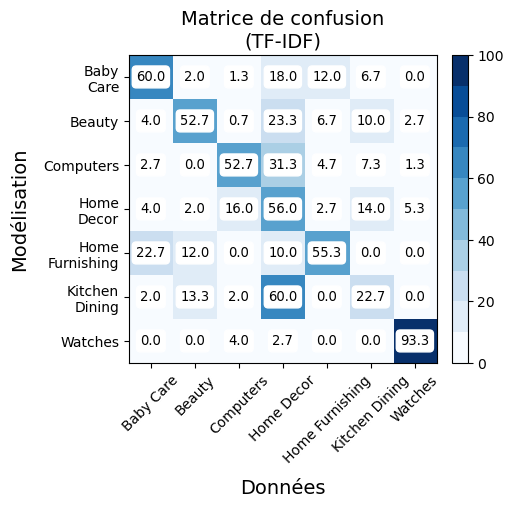

In [69]:
p6.graph_matrix(data["category_label"], data["label_tfidf_bi_2"], "TF-IDF")

Appliquer un filtre sur la variance diminue le score ARI avec l'algorithme TF-IDF. En revanche, pour l'algorithme CountVectorizer, le score ARI augmente.

Nous allons utiliser la méthode que précédemment et appliquer un filtre sur les mots.
<a class="anchor" id="section_3_3"></a>
## Filtres sur des mots et suite de mots

<a class="anchor" id="section_3_1_1"></a>
### Recherche de mots et suite de mots à supprimer

In [70]:
liste_dico_cvect_bi = [col for col in df_cvect_2_3.iloc[:,2:].columns]

for i in range(len(liste_dico_cvect_bi)):
    liste_dico_cvect_bi[i] = {}
    
i=0
for col in df_cvect_2_3.iloc[:,2:].columns:
    for cat in data["Main_category"].unique():
        liste_dico_cvect_bi[i][f"{cat}"] = df_cvect_2_3.loc[df_cvect_2_3["Main_category"]==cat, col].sum()
    i+=1
    
liste_dico_cvect_bi_df = pd.DataFrame(liste_dico_cvect_bi, index = df_cvect_2_3.iloc[:,2:].columns).reset_index()
liste_dico_cvect_bi_df = liste_dico_cvect_bi_df.rename(columns = {"index" : "Colonne"})

In [71]:
words_to_remove_bi = ["girl", "detail", "fabric", "boy", "specification", "ideal", "package", "feature", "sale package", 
                      "sale", "color", "wash", "pattern", "pack", "price", "number content", "number content sale", 
                      "set", "care", "warranty",  "quality", "skin", "brand", "model", "print", "size", "shape", "type", 
                      "multicolor", "best", "inch", "wall", "home", "rs", "number", "gift",  "material", "box", 
                      "dimension", "beautiful", "key", "light", "width", "design", "height", "general", "perfect",
                      "one", "give", "come", "great", "resistant", "water", "round"]

display(len(words_to_remove_bi))

54

In [72]:
col_to_keep_bi = df_cvect_2_3.iloc[:,2:].columns

display(len(col_to_keep_bi))
col_to_keep_bi = [elem for elem in col_to_keep_bi if elem not in words_to_remove_bi]
display(len(col_to_keep_bi))

df_cvect_less_words_bi = df_cvect_2_3[col_to_keep_bi]
df_tfidf_less_words_bi = df_tfidf_2_3[col_to_keep_bi]

display(df_cvect_less_words_bi.shape)
display(df_tfidf_less_words_bi.shape)

X_cvect_bi_3 = df_cvect_less_words_bi.values

X_tfidf_bi_3 = df_tfidf_less_words_bi.values

5000

4948

(1050, 4948)

(1050, 4948)

<a class="anchor" id="section_3_3_2"></a>
### Visualisation t-SNE

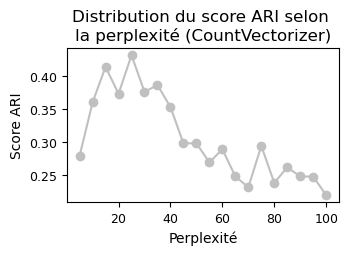

In [73]:
best_perp_cvect_bi_3 = p6.best_perplexity(lab_category, X_cvect_bi_3, "CountVectorizer", 
                                          perp_min = 5, perp_max = 105, step = 5, n_clusters = n_clusters)

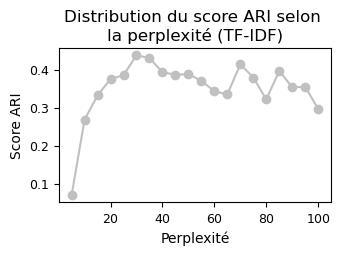

In [74]:
best_perp_tfidf_bi_3 = p6.best_perplexity(lab_category, X_tfidf_bi_3, "TF-IDF", 
                                          perp_min = 5, perp_max = 105, step = 5, n_clusters = n_clusters)

Pour le modèle CountVectorizer, le score ARI est : 0.41754


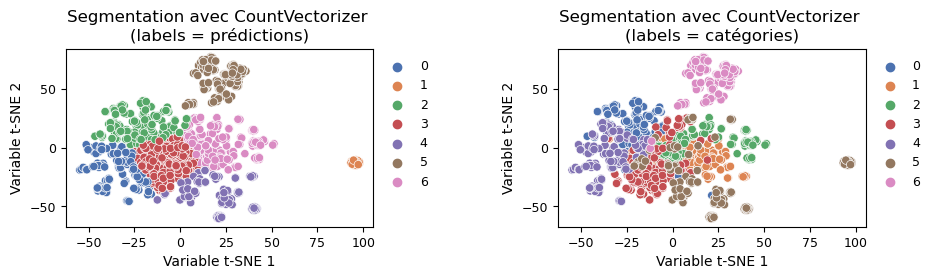

In [75]:
ARI_cvect_bi_3, lab_cvect_bi_3 = p6.graph_t_sne("CountVectorizer", best_perp_cvect_bi_3,
                                                X_cvect_bi_3, lab_category, n_clusters = 7)

Pour le modèle TF-IDF, le score ARI est : 0.43782


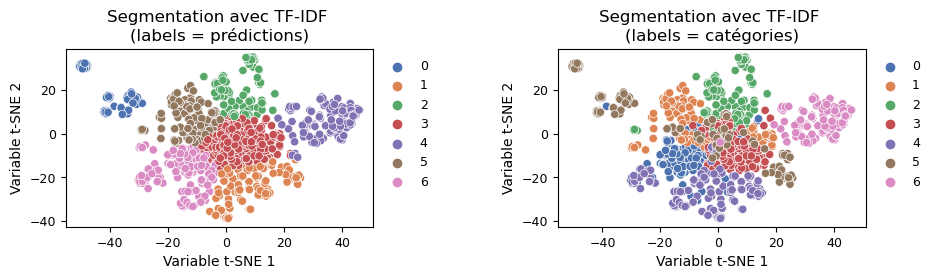

In [76]:
ARI_tfidf_bi_3, lab_tfidf_bi_3 = p6.graph_t_sne("TF-IDF", best_perp_tfidf_bi_3,
                                                X_tfidf_bi_3, lab_category, n_clusters = 7)

In [77]:
method.append("Filtres\nmots (bi-tri)")
method.append("Filtres\nmots (bi-tri)")
Score_ARI.append(ARI_cvect_bi_3)
Score_ARI.append(ARI_tfidf_bi_3)

<a class="anchor" id="section_3_3_3"></a>
### Matrice de confusion

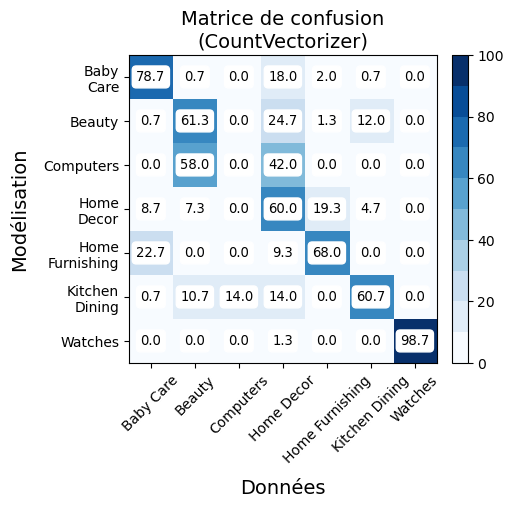

In [78]:
data["label_cvect_bi_3"] = pd.Series(lab_cvect_bi_3)
data["label_tfidf_bi_3"] = pd.Series(lab_tfidf_bi_3)

p6.graph_matrix(data["category_label"], data["label_cvect_bi_3"], "CountVectorizer")

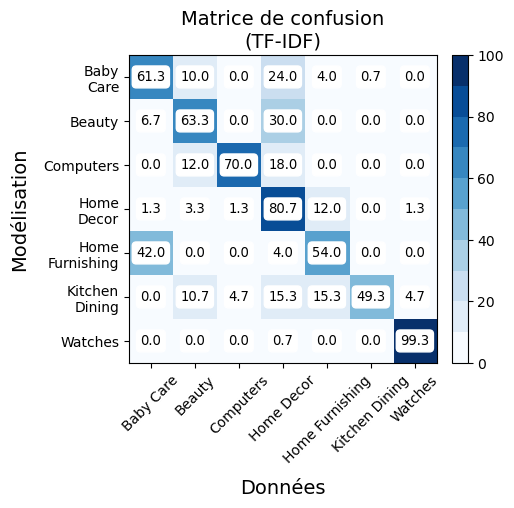

In [79]:
p6.graph_matrix(data["category_label"], data["label_tfidf_bi_3"], "TF-IDF")

Pour l'algorithme TF-IDF, appliquer un filtre sur les mots rend le score ARI meilleur qu'avec le filtre sur la variance. Cependant, le score ARI reste inférieur à celui obtenu sans aucun filtre (0,504).  mais ce n'est pas e score ARI avec l'algorithme TF-IDF. 

Concernant l'algorithme CountVectorizer, le score ARI ne varie pas avec ou sans filtre sur les mots.

Nous allons faire un bilan de l'étude afin de savoir dans qulle configuration nous avons les meilleurs résultats.
<a class="anchor" id="section_3_4"></a>
## Bilan de l'étude

In [80]:
data_score = pd.DataFrame(list(zip(method, Score_ARI)), columns = ['Méthode','Score_ARI'])

data_score["color"] = np.nan
data_score["Nom"] = np.nan

data_score.iloc[0::2,2] = "gray"
data_score.iloc[1::2,2] = "firebrick"

data_score.iloc[0::2,3] = "CountVectorizer"
data_score.iloc[1::2,3] = "TF-IDF"

liste_col = data_score["color"].unique()

liste_methode = data_score["Méthode"].unique()

data_score = data_score.reindex([0, 2, 4, 6, 8, 10, 1, 3, 5, 7, 9, 11]).reset_index(drop=True)

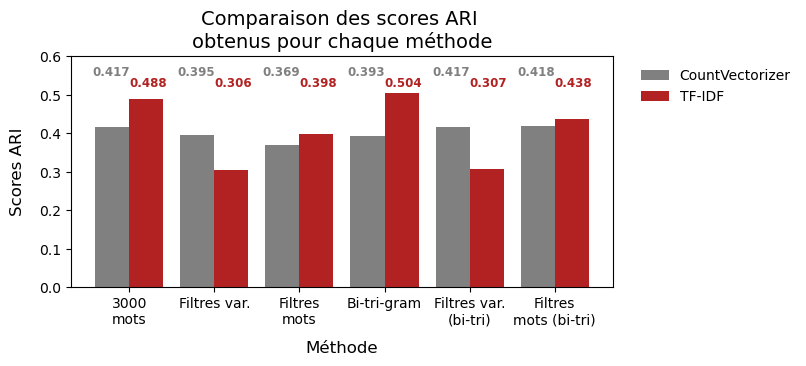

In [81]:
plt.figure(figsize=(7,3))

x_axis = np.arange(6)
plt.bar(height = data_score.iloc[0:6,1], 
        x = x_axis-0.2, width = 0.4,
        color = "gray", label = "CountVectorizer")

plt.bar(height = data_score.iloc[6:,1], 
        x = x_axis+0.2, width = 0.4,
        color = "firebrick", label = "TF-IDF")

for i in range (0, len(x_axis),1): 
    plt.text(i-0.22, 0.55, f"{round(data_score.iloc[i,1],3)}",
             fontsize=8.5, ha="center", color="gray", weight="bold")
    plt.text(i+0.22, 0.52, f"{round(data_score.iloc[i+6,1],3)}",
             fontsize=8.5, ha="center", color="firebrick", weight="bold")
    
plt.ylim(0,0.6)

plt.xlabel("Méthode", fontsize=12, labelpad = 10)
plt.ylabel("Scores ARI", fontsize=12, labelpad = 10)

plt.xticks(x_axis, liste_methode, fontsize=10)
plt.yticks(fontsize=10)

plt.title("Comparaison des scores ARI \nobtenus pour chaque méthode", fontsize=14)

plt.legend(frameon = False, bbox_to_anchor=(1.35,1), fontsize = 10)
plt.show()

Nous voyons que l'algorithme TF-IDF est plus efficace que l'algorithme CountVectorizer globalement. Le fait d'appliquer des filtres n'améliore pas le score ARI pour l'algorithme TF-IDF. En revanche, considérer les n-grams améliore le score ARI.

Pour l'algorithme CountVectorizer, le score ARI reste globalement stable quelque soit la méthode.

Nous allons exporter les scores ARIs qui seront comparés aux résultats des autres algorithmes de texte. De plus nous exportons les données avec TF-IDF dans l'optique d'effectuer une méthode mixte.

In [84]:
data.to_csv('C:/Users/farid/Anaconda/Notebook/data_projet_6.csv')

In [85]:
data_score.to_csv('C:/Users/farid/Anaconda/Notebook/score_ari_text_1_projet_6.csv')

In [32]:
df_X_tfidf_2_3 = pd.DataFrame(X_tfidf_2_3)

df_feat_tfidf = pd.merge(data[["image"]], df_X_tfidf_2_3, 
                         left_index=True, right_index=True, how="outer")


In [35]:
df_feat_tfidf.iloc[:,:5].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   1050 non-null   object 
 1   0       1050 non-null   float64
 2   1       1050 non-null   float64
 3   2       1050 non-null   float64
 4   3       1050 non-null   float64
dtypes: float64(4), object(1)
memory usage: 41.1+ KB


In [34]:
df_feat_tfidf.to_csv('C:/Users/farid/Anaconda/Notebook/data_tfidf_projet_6.csv')